<a href="https://colab.research.google.com/github/anjanavasudevan/Thesis/blob/main/Quadrotor_simulation/controllers/DeepRL/DDPG_Hover.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 8.4 MB/s 
     |████████████████████████████████| 181 kB 67.9 MB/s 
     |████████████████████████████████| 145 kB 69.3 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=0834359926998e5ccfe3c81c54ae010cd89812adccbb84cc7361ce96970cf412
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [ ]:
!pip uninstall torch

Found existing installation: torch 1.11.0+cu113
Uninstalling torch-1.11.0+cu113:
  Would remove:
    /usr/local/bin/convert-caffe2-to-onnx
    /usr/local/bin/convert-onnx-to-caffe2
    /usr/local/bin/torchrun
    /usr/local/lib/python3.7/dist-packages/caffe2/*
    /usr/local/lib/python3.7/dist-packages/torch-1.11.0+cu113.dist-info/*
    /usr/local/lib/python3.7/dist-packages/torch/*
Proceed (y/n)? y
y
  Successfully uninstalled torch-1.11.0+cu113


In [ ]:
!pip install torch==1.5.0 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached torch-1.5.0-cp37-cp37m-manylinux1_x86_64.whl (752.0 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.12.0+cu113 requires torch==1.11.0, but you have torch 1.5.0 which is incompatible.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.5.0 which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.5.0 which is incompatible.


In [ ]:
# Initialize wandb
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
!wandb login

wandb: Currently logged in as: anjanav24. Use `wandb login --relogin` to force relogin


In [ ]:
import os
import sys
sys.path.insert(0, '/content/')
from hover_state_space import hover_state_space
env = hover_state_space()

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [ ]:
"""
a = np.array([[1, 2, 3, 4]])
a = torch.tensor(a)

a = torch.squeeze(a)
a
"""

'\na = np.array([[1, 2, 3, 4]])\na = torch.tensor(a)\n\na = torch.squeeze(a)\na\n'

## DDPG using MLP

In [ ]:
# All imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.multiprocessing as mp
from torch.distributions import Normal

import math
import random
import numpy as np

In [ ]:
torch.__version__

'1.11.0+cu113'

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## MLP Nets

In [ ]:
class ActorNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, init_w=3e-3):
        super(ActorNetwork, self).__init__()
        self.action_dim=output_dim
        
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, output_dim) # output dim = dim of action

        # weights initialization
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
    

    def forward(self, state):
        activation=F.relu
        x = activation(self.linear1(state)) 
        x = activation(self.linear2(x))
        # x = F.tanh(self.linear3(x)).clone() # need clone to prevent in-place operation (which cause gradients not be drived)
        x = self.linear3(x) # for simplicity, no restriction on action range
        mu = torch.tanh(x)
        return mu

    def select_action(self, state, noise_scale=1.0):
        '''
        select action for sampling, no gradients flow, noisy action, return .cpu
        '''
        state = torch.FloatTensor(state).unsqueeze(0).to(device) # state dim: (N, dim of state)
        normal = Normal(0, 1)
        action = self.forward(state)
        noise = noise_scale * normal.sample(action.shape).to(device)
        action+=noise

        # Allow only positive voltages
        action = torch.clamp(torch.abs(action), min=2, max=24)
        action = torch.squeeze(action)
        return action.detach().cpu().numpy()

    def sample_action(self, action_range=1.):
        normal = Normal(0, 1)
        random_action=action_range*normal.sample( (self.action_dim,) )
        random_action = torch.clamp(torch.abs(random_action), min=2, max=24)
        random_action = torch.squeeze(random_action)
        return random_action.cpu().numpy()


    def evaluate_action(self, state, noise_scale=0.0):
        '''
        evaluate action within GPU graph, for gradients flowing through it, noise_scale controllable
        '''
        normal = Normal(0, 1)
        action = self.forward(state)
        # action = torch.tanh(action)
        noise = noise_scale * normal.sample(action.shape).to(device)
        action = torch.clamp(torch.abs(action), min=2, max=24)
        action = torch.squeeze(action)
        action+=noise
        return action

In [ ]:
class QNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, init_w=3e-3):
        super(QNetwork, self).__init__()
        
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, 1)
        self.out = nn.Sigmoid()
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state, action):
        x = torch.cat([state, action], 1) # the dim 0 is number of samples
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        x = self.out(x)
        return x

In [ ]:
class DDPG():
    def __init__(self, replay_buffer, state_dim, action_dim, hidden_dim):
        self.replay_buffer = replay_buffer
        self.qnet = QNetwork(state_dim+action_dim, hidden_dim).to(device)
        self.target_qnet = QNetwork(state_dim+action_dim, hidden_dim).to(device)
        self.policy_net = ActorNetwork(state_dim, action_dim, hidden_dim).to(device)
        self.target_policy_net = ActorNetwork(state_dim, action_dim, hidden_dim).to(device)

        print('Q network: ', self.qnet)
        print('Policy network: ', self.policy_net)

        for target_param, param in zip(self.target_qnet.parameters(), self.qnet.parameters()):
            target_param.data.copy_(param.data)
        self.q_criterion = nn.MSELoss()
        q_lr=1e-3
        policy_lr = 1e-4
        self.update_cnt=0

        self.q_optimizer = optim.Adam(self.qnet.parameters(), lr=q_lr)
        self.policy_optimizer = optim.Adam(self.policy_net.parameters(), lr=policy_lr)
    
    def target_soft_update(self, net, target_net, soft_tau):
    # Soft update the target net
        for target_param, param in zip(target_net.parameters(), net.parameters()):
            target_param.data.copy_(  # copy data value into target parameters
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )

        return target_net

    def update(self, batch_size, reward_scale=10.0, gamma=0.99, soft_tau=1e-2, policy_up_itr=10, target_update_delay=3, warmup=True):
        self.update_cnt+=1
        experiences = self.replay_buffer.sample(batch_size, False)
        state, action, reward, next_state, done = zip(*experiences)
        #state, action, reward, next_state, done = self.replay_buffer.sample(batch_size)
        # print('sample:', state, action,  reward, done)
        #print(reward)
        #print(done)

        state      = torch.FloatTensor(state).to(device)
        next_state = torch.FloatTensor(next_state).to(device)
        action     = torch.FloatTensor(action).to(device)
        # Use view instead of unsqueeze
        reward = torch.FloatTensor(reward).reshape(-1, 1).to(device)
        done = torch.FloatTensor(np.float32(done)).reshape(-1, 1).to(device)
        #reward     = torch.FloatTensor(reward).unsqueeze(1).to(device)  
        #done       = torch.FloatTensor(np.float32(done)).unsqueeze(1).to(device)

        #print(reward)
        #print(done)

        predict_q = self.qnet(state, action) # for q 
        new_next_action = self.target_policy_net.evaluate_action(next_state)  # for q
        new_action = self.policy_net.evaluate_action(state) # for policy
        self.qnet(state, new_action) # for policy
        target_q = reward+(1-done)*gamma*self.target_qnet(next_state, new_next_action)  # for q
        # reward = reward_scale * (reward - reward.mean(dim=0)) /reward.std(dim=0) # normalize with batch mean and std

        # train qnet
        q_loss = self.q_criterion(predict_q, target_q)
        self.q_optimizer.zero_grad()
        q_loss.backward()
        self.q_optimizer.step()

        # train policy_net
        policy_loss = -torch.mean(self.qnet(state, action))
        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        self.policy_optimizer.step()

            
        # update the target_qnet
        if self.update_cnt%target_update_delay==0:
            self.target_qnet=self.target_soft_update(self.qnet, self.target_qnet, soft_tau)
            self.target_policy_net=self.target_soft_update(self.policy_net, self.target_policy_net, soft_tau)

        return q_loss.detach().cpu().numpy(), policy_loss.detach().cpu().numpy()

In [ ]:
from collections import deque
class ReplayBuffer(object):
    def __init__(self, memory_size: int) -> None:
        self.memory_size = memory_size
        self.buffer = deque(maxlen=self.memory_size)

    def add(self, experience) -> None:
        self.buffer.append(experience)

    def size(self):
        return len(self.buffer)

    def sample(self, batch_size: int, continuous: bool = True):
        if batch_size > len(self.buffer):
            batch_size = len(self.buffer)
        if continuous:
            rand = random.randint(0, len(self.buffer) - batch_size)
            return [self.buffer[i] for i in range(rand, rand + batch_size)]
        else:
            indexes = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
            return [self.buffer[i] for i in indexes]

    def clear(self):
        self.buffer.clear()

In [ ]:
action_dim = env.action_space.shape[0]
state_dim  = env.observation_space.shape[0]
hidden_dim = 128
explore_steps = 0  # for random exploration
batch_size = 100

replay_buffer_size=1000000
replay_buffer = ReplayBuffer(replay_buffer_size)

torch.autograd.set_detect_anomaly(True)
alg = DDPG(replay_buffer, state_dim, action_dim, hidden_dim)

q_loss_list = []
policy_loss_list = []

Q network:  QNetwork(
  (linear1): Linear(in_features=10, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=1, bias=True)
  (out): Sigmoid()
)
Policy network:  ActorNetwork(
  (linear1): Linear(in_features=6, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=4, bias=True)
)


In [ ]:
# Initialize
wandb.init(project="Deep-RL-for-Hover", entity="anjanav24")

In [ ]:
replay_buffer.size()

0

In [ ]:
# hyper-parameters
max_episodes  = 1000
max_steps   = 200
frame_idx   = 0
rewards=[]

for i_episode in range (max_episodes):
  episode_q_loss=[]
  episode_policy_loss=[]
  state = env.reset()
  episode_reward = 0

  for step in range(max_steps):
    if frame_idx > explore_steps:
      action = alg.policy_net.sample_action(action_range=1.)
      #if i_episode % 100 == 0:
        #print(action)
    else:
      action = alg.policy_net.select_action(state)
    next_state, reward, done = env.step(action)
    state = next_state
    replay_buffer.add((state, action, reward, next_state, done))
                
    state = next_state
    episode_reward += reward
    frame_idx += 1
                
    if replay_buffer.size() > batch_size:
      q_loss, policy_loss = alg.update(batch_size)
      episode_q_loss.append(float(q_loss))
      episode_policy_loss.append(float(policy_loss))
                
    if done:
      break
  if i_episode % 10 == 0:
    print('Eps: ', i_episode, '| Reward: ', episode_reward, '| Loss: ', np.average(q_loss_list), np.average(policy_loss_list))
  
  wandb.log({"Epoch": i_episode, "Rewards": rewards, "Policy loss": np.mean(episode_policy_loss),\
             "Critic loss": np.mean(episode_q_loss)})
  
  q_loss_list.append(np.mean(episode_q_loss))
  policy_loss_list.append(np.mean(episode_policy_loss))
  rewards.append(episode_reward)
  """         
  rewards.append(episode_reward)
  writer.add_scalar('Rewards', episode_reward, i_episode)
  q_loss_list.append(np.mean(episode_q_loss))
  writer.add_scalar('Q_Loss', np.mean(episode_q_loss), i_episode)
  policy_loss_list.append(np.mean(episode_policy_loss))
  writer.add_scalar('Policy_loss', np.mean(episode_policy_loss), i_episode)
  """

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Eps:  0 | Reward:  -4079.417339993814 | Loss:  nan nan
Eps:  10 | Reward:  -4281.383000752698 | Loss:  2291.4321981811527 -0.007920745875079335
Eps:  20 | Reward:  -2162.0655644368267 | Loss:  2369.5236833801273 -0.0039603729391149865
Eps:  30 | Reward:  -3690.584239225853 | Loss:  2452.8937950642908 -0.0026402486264217244
Eps:  40 | Reward:  -2609.1114393419457 | Loss:  2475.3452344970706 -0.0019801864699217097
Eps:  50 | Reward:  -1092.861513259345 | Loss:  2468.5967152221683 -0.0015841491759829409
Eps:  60 | Reward:  -8548.009706582385 | Loss:  2436.1814618733724 -0.0013201243133463892
Eps:  70 | Reward:  -9412.56151825689 | Loss:  2395.4573385009767 -0.0011315351257396773
Eps:  80 | Reward:  -8845.496385840455 | Loss:  2374.9719752731326 -0.00099009323503036
Eps:  90 | Reward:  -8122.147154250256 | Loss:  2356.417836107042 -0.0008800828755878198
Eps:  100 | Reward:  -15509.873660121802 | Loss:  2338.7462810485845 -0.000792074588032625
Eps:  110 | Reward:  -7498.064582145689 | Loss:

KeyboardInterrupt: ignored

In [ ]:
with torch.no_grad():
  torch.cuda.empty_cache()

In [ ]:
r_list = (-776.1269321698996, -324.75605204451875, -757.7996585856293, -577.2818708567689, -670.9547046865756, -562.7877284903376, -998.8091632949915, -446.72304146472084, -281.3922753703698, -348.13214960718676, -304.2603775518396, -892.7985533067416, -1136.5630061299491, -976.9681860943682, -374.3555467707023, -813.7397621429006, -534.7577265619346, -332.22637826114914, -638.4527163373602, -872.5547141135515, -622.6808635649825, -356.5538657670496, -722.1033942215479, -317.6049431874237, -435.4265792530769, -687.684840263413, -913.3618201014184, -592.0954408246869, -521.2218669999633, -1160.6399765409785, -1043.4494005006975, -393.43489268625785, -470.27544785375795, -271.8728948103557, -654.5439967112245, -482.5308539229683, -1089.36734811235, -1066.2486605057804, -365.29499815488816, -403.45368998599906, -340.0319071751851, -852.6303025218479, -458.3389199043405, -286.63050624977785, -424.4495332694086, -548.6130137253928, -292.19783290278235, -833.0253185316311, -1112.805463320406, -276.4730715572291, -383.73551161449217, -739.7918126028453, -1020.9695680971013, -298.06692077335055, -495.10843068048, -267.5917451297497, -413.79190351371597, -704.7344034417372, -310.773051689864, -607.2284383940914, -934.2445144975819, -508.0054350394783, -955.4466364952317, -794.7736333556569)

In [ ]:
r = torch.Tensor(r_list)

In [ ]:
r_unsqueezed = r.unsqueeze(1)
r_unsqueezed.shape

In [ ]:
r_view = r.view(r.shape[0], -1)
r_view.shape

In [ ]:
r_reshape = r.reshape(-1, 1)
r_reshape.shape

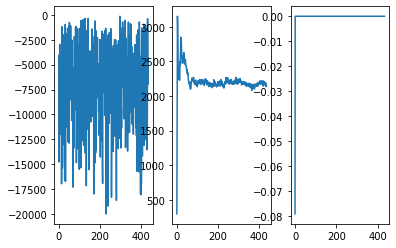

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.subplot(1, 3, 1)
plt.plot(rewards)

plt.subplot(1, 3, 2)
plt.plot(q_loss_list)

plt.subplot(1, 3, 3)
plt.plot(policy_loss_list)
plt.show()

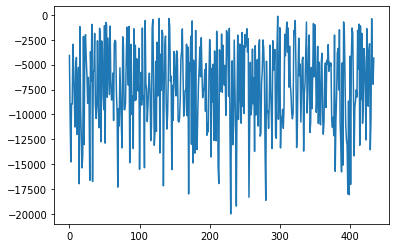

In [ ]:
plt.plot(rewards)